In [1]:
NEURON_LAYER = 256
EPOCH = 250
ATTR_NOW = 'humidity'

In [2]:
attr_dict = {
    'min_temp': ('mnt', 'Temperatur minimum'),
    'max_temp': ('mxt', 'Temperatur maksimum'),
    'avg_temp': ('avgt', 'Temperatur rata-rata'),
    'humidity': ('hum', 'Kelembapan rata-rata'),
    'sunshine': ('sun', 'Penyinaran matahari'),
    'rainfall': ('rain', 'Curah hujan'),
}

ATTR_CODE = attr_dict[ATTR_NOW][0]
ATTR_NAME = attr_dict[ATTR_NOW][1]

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import statsmodels.graphics.tsaplots as sgt
import random

from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt

In [4]:
random.seed(7)

In [5]:
df = pd.read_csv('../attributes_dataset/humidity.csv')
df.date = pd.to_datetime(df.date, format='%Y-%m-%d')
df.set_index('date', inplace=True)
df.columns = ['y']
df.head()

,y
date,
2018-01-01,87.5
2018-01-02,94.0
2018-01-03,94.0
2018-01-04,88.0
2018-01-05,89.0


# Convert Dataframe to Array

In [6]:
def df_to_array(df, window_size):
    df_y_np = df.y.to_numpy()
    df_index_np = df.index.to_numpy()
    
    x = []
    y = []
    date = []
    for i in range(len(df_index_np) - window_size):
        row = [[a] for a in df_y_np[i:i+window_size]]
        x.append(row)
        label = df_y_np[i+window_size]
        y.append(label)
        index = df_index_np[i+window_size]
        date.append(index)
        
    return np.array(x), np.array(y), np.array(date)

# Configure time step

In [7]:
WINDOW_SIZE = 20

# Split the Data

In [8]:
train_ratio = int(len(df) * 0.8)
test_ratio = train_ratio + int(len(df) * 0.1)

dtrain, dval, dtest = df.iloc[:train_ratio], df.iloc[(train_ratio - WINDOW_SIZE):test_ratio], df.iloc[(test_ratio - WINDOW_SIZE):]

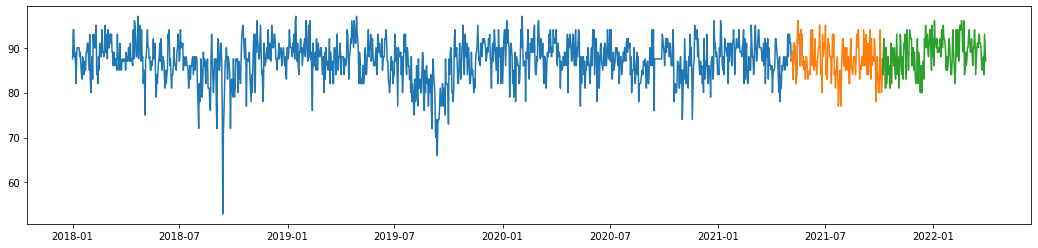

In [9]:
plt.figure(figsize=(18,4))
plt.plot(dtrain)
plt.plot(dval)
plt.plot(dtest)

# Standarization Function

In [10]:
dev_val = dtrain.std()[0]
mean_val = dtrain.mean()[0]

def make_std(data):
    data_std = data    
    data_std = (data_std-mean_val)/dev_val
    
    return data_std

In [11]:
dtrain_std = make_std(dtrain)

In [12]:
dval_std = make_std(dval)

In [13]:
dtest_std = make_std(dtest)

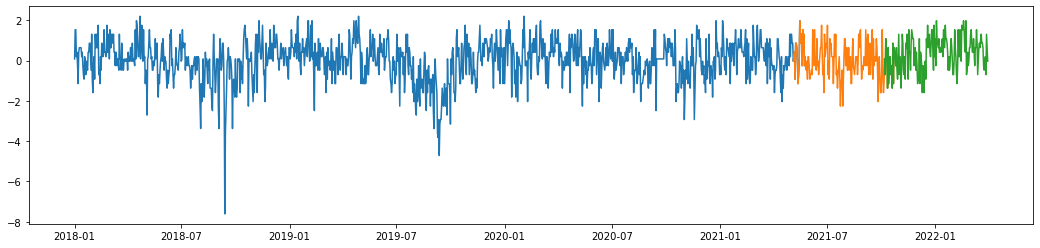

In [14]:
plt.figure(figsize=(18,4))
plt.plot(dtrain_std)
plt.plot(dval_std)
plt.plot(dtest_std)

# De-standarization Function

In [15]:
def de_std(df):
    column = ['Predictions', 'Actuals']
    for index, row in df.iterrows():
        for col in column:
            val = df.loc[index, col]
            df.loc[index, col] = (dev_val * val) + mean_val        

# Executing Forecast

In [16]:
def execute_forecast(pred, actual, date):
    df_result = pd.DataFrame(data={'date': date, 'Predictions': pred, 'Actuals': actual})
    df_result.set_index('date', inplace=True)
    
    de_std(df_result)
    
    plt.figure(figsize=(18,8))
    plt.plot(df_result['Actuals'], 'r--')
    plt.plot(df_result['Predictions'], 'b')

    plt.show()
    
    MAE = mean_absolute_error(df_result['Actuals'], df_result['Predictions'])
    RMSE = sqrt(mean_squared_error(df_result['Actuals'], df_result['Predictions']))

    print(f'Mean Absolute Error is\t\t: {MAE}')
    print(f'Root Mean Squared Error is\t: {RMSE}')
    
    return df_result, MAE, RMSE

## Get x and y values

In [17]:
X_train, y_train, date_train = df_to_array(dtrain_std, WINDOW_SIZE)
X_val, y_val, date_val = df_to_array(dval_std, WINDOW_SIZE)
X_test, y_test, date_test = df_to_array(dtest_std, WINDOW_SIZE)

# Creating the Model

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

In [19]:
model_loc = 'LSTM_models/'+ATTR_CODE+'_n'+str(NEURON_LAYER)+'_e'+str(EPOCH)+'/'

# Create and saving the Model

In [20]:
model = Sequential()
model.add(InputLayer((WINDOW_SIZE,1)))
model.add(LSTM(NEURON_LAYER))
model.add(Dense(64, 'relu'))
model.add(Dense(1, 'linear'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 256)               264192    
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 280,705
Trainable params: 280,705
Non-trainable params: 0
_________________________________________________________________


In [21]:
cp = ModelCheckpoint(model_loc, save_best_only=True)

In [22]:
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [23]:
%%time
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=EPOCH, callbacks=[cp])

Epoch 1/250
38/39 [============================>.] - ETA: 0s - loss: 0.9233 - root_mean_squared_error: 0.9609

INFO:tensorflow:Assets written to: LSTM_models/hum_n256_e250\assets


INFO:tensorflow:Assets written to: LSTM_models/hum_n256_e250\assets


39/39 [==============================] - 9s 184ms/step - loss: 0.9236 - root_mean_squared_error: 0.9610 - val_loss: 0.6916 - val_root_mean_squared_error: 0.8316
Epoch 2/250
39/39 [==============================] - 2s 50ms/step - loss: 0.8109 - root_mean_squared_error: 0.9005 - val_loss: 0.7021 - val_root_mean_squared_error: 0.8379
Epoch 3/250
39/39 [==============================] - 2s 52ms/step - loss: 0.7944 - root_mean_squared_error: 0.8913 - val_loss: 0.6978 - val_root_mean_squared_error: 0.8354
Epoch 4/250
39/39 [==============================] - 2s 55ms/step - loss: 0.7822 - root_mean_squared_error: 0.8844 - val_loss: 0.7007 - val_root_mean_squared_error: 0.8371
Epoch 5/250
39/39 [==============================] - 2s 56ms/step - loss: 0.7705 - root_mean_squared_error: 0.8778 - val_loss: 0.7031 - val_root_mean_squared_error: 0.8385
Epoch 6/250
39/39 [==============================] - 2s 63ms/step - loss: 0.7622 - root_mean_squared_error: 0.8730 - val_loss: 0.7031 - val_root_mean_s

39/39 [==============================] - 2s 56ms/step - loss: 0.6992 - root_mean_squared_error: 0.8362 - val_loss: 0.7333 - val_root_mean_squared_error: 0.8563
Epoch 49/250
39/39 [==============================] - 2s 58ms/step - loss: 0.7002 - root_mean_squared_error: 0.8368 - val_loss: 0.7271 - val_root_mean_squared_error: 0.8527
Epoch 50/250
39/39 [==============================] - 2s 55ms/step - loss: 0.7006 - root_mean_squared_error: 0.8370 - val_loss: 0.7359 - val_root_mean_squared_error: 0.8579
Epoch 51/250
39/39 [==============================] - 2s 54ms/step - loss: 0.7017 - root_mean_squared_error: 0.8377 - val_loss: 0.7291 - val_root_mean_squared_error: 0.8539
Epoch 52/250
39/39 [==============================] - 2s 54ms/step - loss: 0.6970 - root_mean_squared_error: 0.8348 - val_loss: 0.7316 - val_root_mean_squared_error: 0.8553
Epoch 53/250
39/39 [==============================] - 2s 55ms/step - loss: 0.6985 - root_mean_squared_error: 0.8358 - val_loss: 0.7296 - val_root_me

39/39 [==============================] - 2s 54ms/step - loss: 0.6857 - root_mean_squared_error: 0.8281 - val_loss: 0.7386 - val_root_mean_squared_error: 0.8594
Epoch 96/250
39/39 [==============================] - 2s 53ms/step - loss: 0.6866 - root_mean_squared_error: 0.8286 - val_loss: 0.7350 - val_root_mean_squared_error: 0.8573
Epoch 97/250
39/39 [==============================] - 2s 54ms/step - loss: 0.6880 - root_mean_squared_error: 0.8294 - val_loss: 0.7419 - val_root_mean_squared_error: 0.8613
Epoch 98/250
39/39 [==============================] - 2s 55ms/step - loss: 0.6854 - root_mean_squared_error: 0.8279 - val_loss: 0.7388 - val_root_mean_squared_error: 0.8596
Epoch 99/250
39/39 [==============================] - 2s 54ms/step - loss: 0.6841 - root_mean_squared_error: 0.8271 - val_loss: 0.7375 - val_root_mean_squared_error: 0.8588
Epoch 100/250
39/39 [==============================] - 2s 55ms/step - loss: 0.6836 - root_mean_squared_error: 0.8268 - val_loss: 0.7405 - val_root_m

39/39 [==============================] - 2s 54ms/step - loss: 0.6658 - root_mean_squared_error: 0.8160 - val_loss: 0.7553 - val_root_mean_squared_error: 0.8691
Epoch 143/250
39/39 [==============================] - 2s 54ms/step - loss: 0.6568 - root_mean_squared_error: 0.8104 - val_loss: 0.7588 - val_root_mean_squared_error: 0.8711
Epoch 144/250
39/39 [==============================] - 2s 55ms/step - loss: 0.6705 - root_mean_squared_error: 0.8188 - val_loss: 0.7598 - val_root_mean_squared_error: 0.8716
Epoch 145/250
39/39 [==============================] - 2s 55ms/step - loss: 0.6812 - root_mean_squared_error: 0.8254 - val_loss: 0.7465 - val_root_mean_squared_error: 0.8640
Epoch 146/250
39/39 [==============================] - 2s 54ms/step - loss: 0.6620 - root_mean_squared_error: 0.8136 - val_loss: 0.7544 - val_root_mean_squared_error: 0.8686
Epoch 147/250
39/39 [==============================] - 2s 55ms/step - loss: 0.6591 - root_mean_squared_error: 0.8118 - val_loss: 0.7598 - val_ro

39/39 [==============================] - 2s 55ms/step - loss: 0.6232 - root_mean_squared_error: 0.7895 - val_loss: 0.7708 - val_root_mean_squared_error: 0.8780
Epoch 190/250
39/39 [==============================] - 2s 53ms/step - loss: 0.6257 - root_mean_squared_error: 0.7910 - val_loss: 0.7951 - val_root_mean_squared_error: 0.8917
Epoch 191/250
39/39 [==============================] - 2s 53ms/step - loss: 0.6227 - root_mean_squared_error: 0.7891 - val_loss: 0.7949 - val_root_mean_squared_error: 0.8916
Epoch 192/250
39/39 [==============================] - 2s 53ms/step - loss: 0.6227 - root_mean_squared_error: 0.7891 - val_loss: 0.7886 - val_root_mean_squared_error: 0.8880
Epoch 193/250
39/39 [==============================] - 2s 52ms/step - loss: 0.6224 - root_mean_squared_error: 0.7889 - val_loss: 0.7755 - val_root_mean_squared_error: 0.8807
Epoch 194/250
39/39 [==============================] - 2s 53ms/step - loss: 0.6329 - root_mean_squared_error: 0.7955 - val_loss: 0.7704 - val_ro

39/39 [==============================] - 2s 53ms/step - loss: 0.5787 - root_mean_squared_error: 0.7607 - val_loss: 0.7881 - val_root_mean_squared_error: 0.8877
Epoch 237/250
39/39 [==============================] - 2s 54ms/step - loss: 0.5756 - root_mean_squared_error: 0.7587 - val_loss: 0.7752 - val_root_mean_squared_error: 0.8804
Epoch 238/250
39/39 [==============================] - 2s 53ms/step - loss: 0.5776 - root_mean_squared_error: 0.7600 - val_loss: 0.7859 - val_root_mean_squared_error: 0.8865
Epoch 239/250
39/39 [==============================] - 2s 53ms/step - loss: 0.5724 - root_mean_squared_error: 0.7565 - val_loss: 0.7868 - val_root_mean_squared_error: 0.8870
Epoch 240/250
39/39 [==============================] - 2s 53ms/step - loss: 0.5759 - root_mean_squared_error: 0.7589 - val_loss: 0.7945 - val_root_mean_squared_error: 0.8914
Epoch 241/250
39/39 [==============================] - 2s 54ms/step - loss: 0.5662 - root_mean_squared_error: 0.7524 - val_loss: 0.8130 - val_ro

# Load the Model

In [24]:
model1 = load_model(model_loc)

In [25]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 256)               264192    
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 280,705
Trainable params: 280,705
Non-trainable params: 0
_________________________________________________________________


## Train Results

In [26]:
train_res = model1.predict(X_train).flatten()

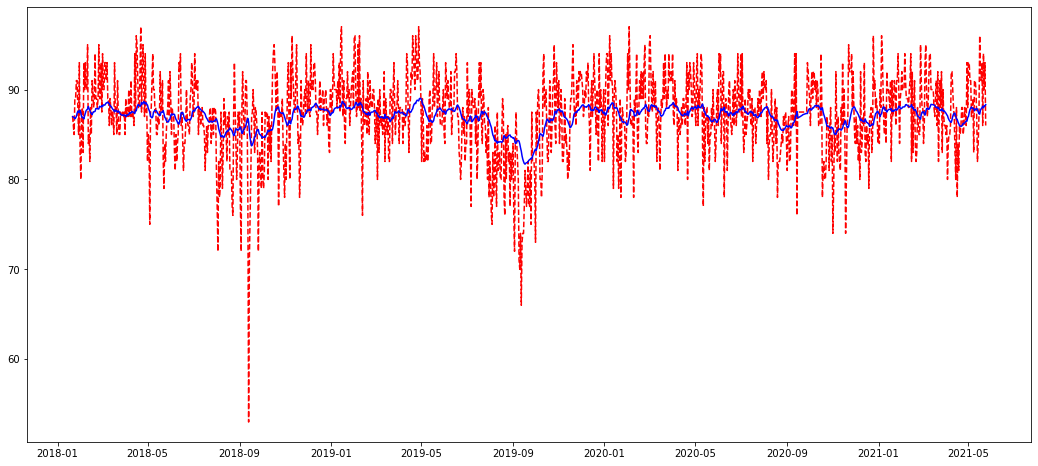

Mean Absolute Error is		: 3.074280022793129
Root Mean Squared Error is	: 4.10573085895368


In [27]:
train_df, train_MAE, train_RMSE = execute_forecast(train_res, y_train, date_train)

## Validation Results

In [28]:
val_res = model1.predict(X_val).flatten()

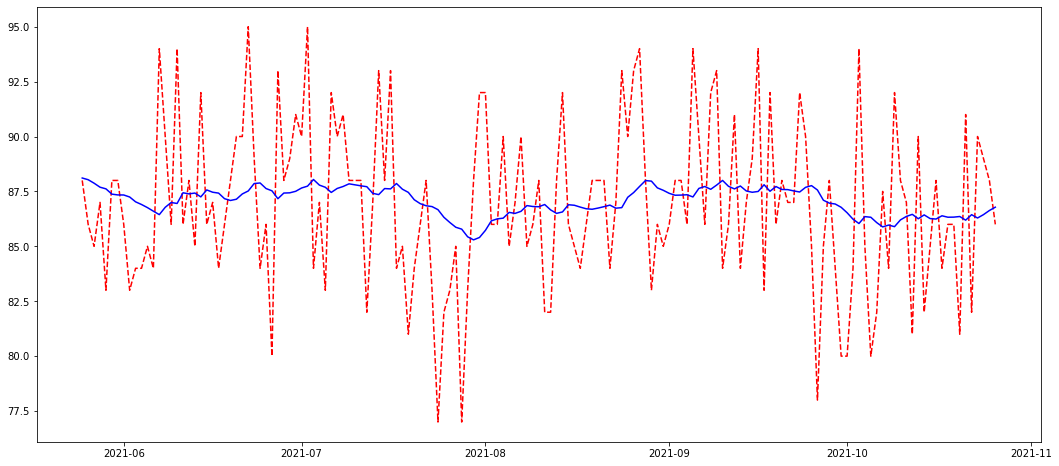

Mean Absolute Error is		: 2.985578869235131
Root Mean Squared Error is	: 3.7302067926103137


In [29]:
val_df, val_MAE, val_RMSE = execute_forecast(val_res, y_val, date_val)

# Updating data validation to model

In [30]:
model_val_loc = model_loc[:-1] + '_val/'

In [31]:
u_cp = ModelCheckpoint(model_val_loc, save_best_only=True)

In [32]:
%%time
model1.fit(X_val, y_val, validation_data=(X_test, y_test), epochs=EPOCH, callbacks=[u_cp])

Epoch 1/250
5/5 [==============================] - ETA: 0s - loss: 0.6921 - root_mean_squared_error: 0.8319

INFO:tensorflow:Assets written to: LSTM_models/hum_n256_e250_val\assets


INFO:tensorflow:Assets written to: LSTM_models/hum_n256_e250_val\assets


5/5 [==============================] - 9s 2s/step - loss: 0.6921 - root_mean_squared_error: 0.8319 - val_loss: 0.6959 - val_root_mean_squared_error: 0.8342
Epoch 2/250
5/5 [==============================] - 0s 81ms/step - loss: 0.6885 - root_mean_squared_error: 0.8297 - val_loss: 0.7096 - val_root_mean_squared_error: 0.8424
Epoch 3/250
5/5 [==============================] - 0s 80ms/step - loss: 0.6859 - root_mean_squared_error: 0.8282 - val_loss: 0.7204 - val_root_mean_squared_error: 0.8488
Epoch 4/250
5/5 [==============================] - 0s 79ms/step - loss: 0.6844 - root_mean_squared_error: 0.8273 - val_loss: 0.7325 - val_root_mean_squared_error: 0.8559
Epoch 5/250
5/5 [==============================] - 0s 80ms/step - loss: 0.6825 - root_mean_squared_error: 0.8261 - val_loss: 0.7425 - val_root_mean_squared_error: 0.8617
Epoch 6/250
5/5 [==============================] - 0s 79ms/step - loss: 0.6812 - root_mean_squared_error: 0.8253 - val_loss: 0.7513 - val_root_mean_squared_error: 0

5/5 [==============================] - 0s 79ms/step - loss: 0.6512 - root_mean_squared_error: 0.8070 - val_loss: 0.9688 - val_root_mean_squared_error: 0.9843
Epoch 50/250
5/5 [==============================] - 0s 78ms/step - loss: 0.6500 - root_mean_squared_error: 0.8062 - val_loss: 0.9604 - val_root_mean_squared_error: 0.9800
Epoch 51/250
5/5 [==============================] - 0s 77ms/step - loss: 0.6493 - root_mean_squared_error: 0.8058 - val_loss: 0.9558 - val_root_mean_squared_error: 0.9777
Epoch 52/250
5/5 [==============================] - 0s 79ms/step - loss: 0.6486 - root_mean_squared_error: 0.8054 - val_loss: 0.9571 - val_root_mean_squared_error: 0.9783
Epoch 53/250
5/5 [==============================] - 0s 79ms/step - loss: 0.6480 - root_mean_squared_error: 0.8050 - val_loss: 0.9681 - val_root_mean_squared_error: 0.9839
Epoch 54/250
5/5 [==============================] - 0s 78ms/step - loss: 0.6470 - root_mean_squared_error: 0.8043 - val_loss: 0.9720 - val_root_mean_squared_e

Epoch 97/250
5/5 [==============================] - 0s 77ms/step - loss: 0.5675 - root_mean_squared_error: 0.7533 - val_loss: 1.4517 - val_root_mean_squared_error: 1.2049
Epoch 98/250
5/5 [==============================] - 0s 78ms/step - loss: 0.5671 - root_mean_squared_error: 0.7530 - val_loss: 1.4184 - val_root_mean_squared_error: 1.1909
Epoch 99/250
5/5 [==============================] - 0s 79ms/step - loss: 0.5654 - root_mean_squared_error: 0.7520 - val_loss: 1.4241 - val_root_mean_squared_error: 1.1934
Epoch 100/250
5/5 [==============================] - 0s 79ms/step - loss: 0.5603 - root_mean_squared_error: 0.7485 - val_loss: 1.4983 - val_root_mean_squared_error: 1.2240
Epoch 101/250
5/5 [==============================] - 0s 89ms/step - loss: 0.5651 - root_mean_squared_error: 0.7518 - val_loss: 1.6151 - val_root_mean_squared_error: 1.2709
Epoch 102/250
5/5 [==============================] - 0s 85ms/step - loss: 0.5609 - root_mean_squared_error: 0.7489 - val_loss: 1.4874 - val_roo

Epoch 145/250
5/5 [==============================] - 0s 79ms/step - loss: 0.4759 - root_mean_squared_error: 0.6898 - val_loss: 2.0127 - val_root_mean_squared_error: 1.4187
Epoch 146/250
5/5 [==============================] - 0s 78ms/step - loss: 0.4725 - root_mean_squared_error: 0.6874 - val_loss: 1.9965 - val_root_mean_squared_error: 1.4130
Epoch 147/250
5/5 [==============================] - 0s 83ms/step - loss: 0.4700 - root_mean_squared_error: 0.6855 - val_loss: 2.0582 - val_root_mean_squared_error: 1.4347
Epoch 148/250
5/5 [==============================] - 0s 78ms/step - loss: 0.4671 - root_mean_squared_error: 0.6834 - val_loss: 2.1140 - val_root_mean_squared_error: 1.4540
Epoch 149/250
5/5 [==============================] - 0s 78ms/step - loss: 0.4772 - root_mean_squared_error: 0.6908 - val_loss: 2.2639 - val_root_mean_squared_error: 1.5046
Epoch 150/250
5/5 [==============================] - 0s 78ms/step - loss: 0.4768 - root_mean_squared_error: 0.6905 - val_loss: 2.2006 - val_

5/5 [==============================] - 0s 81ms/step - loss: 0.3510 - root_mean_squared_error: 0.5925 - val_loss: 2.4744 - val_root_mean_squared_error: 1.5730
Epoch 193/250
5/5 [==============================] - 0s 79ms/step - loss: 0.3655 - root_mean_squared_error: 0.6046 - val_loss: 2.8524 - val_root_mean_squared_error: 1.6889
Epoch 194/250
5/5 [==============================] - 0s 78ms/step - loss: 0.3579 - root_mean_squared_error: 0.5983 - val_loss: 2.1133 - val_root_mean_squared_error: 1.4537
Epoch 195/250
5/5 [==============================] - 0s 77ms/step - loss: 0.3560 - root_mean_squared_error: 0.5967 - val_loss: 2.8176 - val_root_mean_squared_error: 1.6786
Epoch 196/250
5/5 [==============================] - 0s 77ms/step - loss: 0.3526 - root_mean_squared_error: 0.5938 - val_loss: 2.4889 - val_root_mean_squared_error: 1.5776
Epoch 197/250
5/5 [==============================] - 0s 79ms/step - loss: 0.3461 - root_mean_squared_error: 0.5883 - val_loss: 2.6398 - val_root_mean_squa

Epoch 240/250
5/5 [==============================] - 0s 105ms/step - loss: 0.2884 - root_mean_squared_error: 0.5370 - val_loss: 2.2763 - val_root_mean_squared_error: 1.5087
Epoch 241/250
5/5 [==============================] - 0s 108ms/step - loss: 0.2797 - root_mean_squared_error: 0.5289 - val_loss: 3.0121 - val_root_mean_squared_error: 1.7355
Epoch 242/250
5/5 [==============================] - 0s 81ms/step - loss: 0.2919 - root_mean_squared_error: 0.5402 - val_loss: 2.8540 - val_root_mean_squared_error: 1.6894
Epoch 243/250
5/5 [==============================] - 0s 79ms/step - loss: 0.2719 - root_mean_squared_error: 0.5215 - val_loss: 2.2795 - val_root_mean_squared_error: 1.5098
Epoch 244/250
5/5 [==============================] - 0s 79ms/step - loss: 0.2842 - root_mean_squared_error: 0.5331 - val_loss: 3.2590 - val_root_mean_squared_error: 1.8053
Epoch 245/250
5/5 [==============================] - 0s 78ms/step - loss: 0.2950 - root_mean_squared_error: 0.5431 - val_loss: 2.7655 - va

## Test Results

In [33]:
model2 = load_model(model_val_loc)

In [34]:
test_res = model2.predict(X_test).flatten()

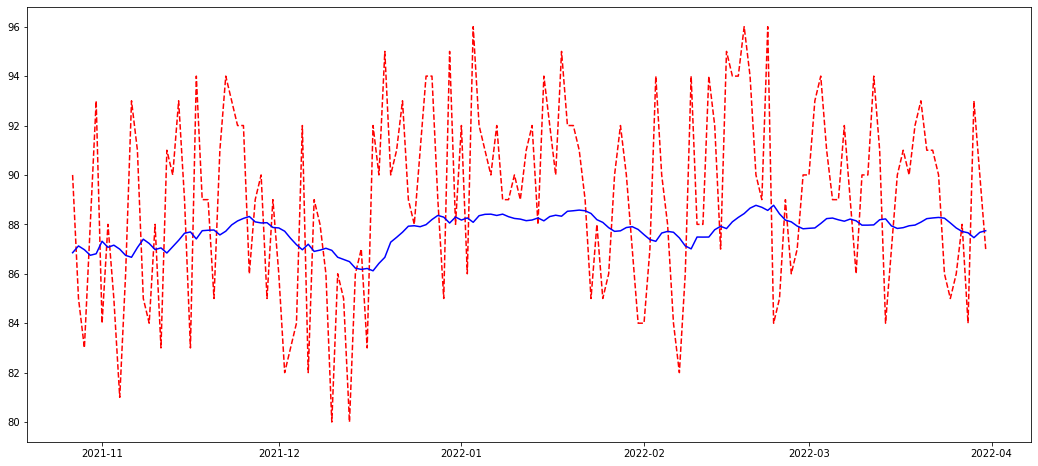

Mean Absolute Error is		: 3.1337727766770582
Root Mean Squared Error is	: 3.741856831247429


In [35]:
test_df, test_MAE, test_RMSE = execute_forecast(test_res, y_test, date_test)

# k-period forecast

In [36]:
def one_step_forecast(model, X):
    X_val = np.array(X)
    result = model.predict(X_val).flatten()
    X_val_update = []
    
    for lags in X_val:
        lags_update = []
        
        for value in lags:
            lags_update.append(value)
        
        lags_update.append(result)
        lags_update = lags_update[1:]
        
        X_val_update.append(lags_update)
    
    return result, np.array(X_val_update)

In [37]:
def LSTM_forecast(model, period, x_input):
    x_input = [x_input]
    final_result = []
    iteration = 0
    while iteration < period:
        result, x_input = one_step_forecast(model, x_input)
        final_result.append(result[0])
        iteration += 1
    return np.array(final_result), x_input

In [38]:
def get_period_forecast(model, X, period, date, y_act=[]):
    res = []
    pred_date = []
    for i in np.arange(0, len(X), period):
        X_start = X[i]
        result, __ = LSTM_forecast(model, period=period, x_input=X_start)
        
        ## updating model
        if len(y_act) > 0:
            for prd in range(0,period):
                if (i+prd) < len(X):
                    X_up = np.reshape(X[i+prd], (1, X.shape[1], X.shape[2]))
                    y_up = np.reshape(y_act[i+prd], (1,))
                    print(f"({i+prd}/{len(X)-1}) updating {date[i+prd]} into model")
                    model.fit(X_up, y_up, epochs=1)
                    
        res.append(result)
        pred_date.append(date[i])
    return np.array(res), np.array(pred_date)

In [39]:
def collect_k_res(k_res, length):
    res_val = []
    counter = 0
    for pred in k_res:
        for val in pred:
            if counter < length:
                res_val.append(val)
            counter += 1
    return np.array(res_val)

In [40]:
def period_forecast(model, period, X, y, date):
    k_res, k_date = get_period_forecast(model, X, period, date, y_act=y)
    k_res_val = collect_k_res(k_res, len(X))
    return k_res_val

In [41]:
def forcast_scene(model_loc, period, X, y, date):
    sc_model = load_model(model_loc)
    sc_frc = period_forecast(sc_model, period=period, X=X, y=y, date=date)
    sc_df, sc_MAE, sc_RMSE = execute_forecast(sc_frc, y_test, date_test)
    return sc_df, sc_MAE, sc_RMSE

# Forecasting scenario

(0/155) updating 2021-10-27T00:00:00.000000000 into model
1/1 [==============================] - 3s 3s/step - loss: 0.4924 - root_mean_squared_error: 0.7017
(1/155) updating 2021-10-28T00:00:00.000000000 into model
1/1 [==============================] - 0s 23ms/step - loss: 0.2320 - root_mean_squared_error: 0.4816
(2/155) updating 2021-10-29T00:00:00.000000000 into model
1/1 [==============================] - 0s 21ms/step - loss: 0.7964 - root_mean_squared_error: 0.8924
(3/155) updating 2021-10-30T00:00:00.000000000 into model
1/1 [==============================] - 0s 24ms/step - loss: 0.0749 - root_mean_squared_error: 0.2737
(4/155) updating 2021-10-31T00:00:00.000000000 into model
1/1 [==============================] - 0s 22ms/step - loss: 1.8904 - root_mean_squared_error: 1.3749
(5/155) updating 2021-11-01T00:00:00.000000000 into model
1/1 [==============================] - 0s 22ms/step - loss: 0.5430 - root_mean_squared_error: 0.7369
(6/155) updating 2021-11-02T00:00:00.000000000 i

1/1 [==============================] - 0s 24ms/step - loss: 1.5772 - root_mean_squared_error: 1.2559
(52/155) updating 2021-12-18T00:00:00.000000000 into model
1/1 [==============================] - 0s 23ms/step - loss: 0.5929 - root_mean_squared_error: 0.7700
(53/155) updating 2021-12-19T00:00:00.000000000 into model
1/1 [==============================] - 0s 22ms/step - loss: 3.3924 - root_mean_squared_error: 1.8419
(54/155) updating 2021-12-20T00:00:00.000000000 into model
1/1 [==============================] - 0s 19ms/step - loss: 0.3799 - root_mean_squared_error: 0.6164
(55/155) updating 2021-12-21T00:00:00.000000000 into model
1/1 [==============================] - 0s 24ms/step - loss: 0.6169 - root_mean_squared_error: 0.7854
(56/155) updating 2021-12-22T00:00:00.000000000 into model
1/1 [==============================] - 0s 22ms/step - loss: 1.3793 - root_mean_squared_error: 1.1744
(57/155) updating 2021-12-23T00:00:00.000000000 into model
1/1 [==============================] - 0

1/1 [==============================] - 0s 23ms/step - loss: 0.8855 - root_mean_squared_error: 0.9410
(103/155) updating 2022-02-07T00:00:00.000000000 into model
1/1 [==============================] - 0s 28ms/step - loss: 1.6699 - root_mean_squared_error: 1.2923
(104/155) updating 2022-02-08T00:00:00.000000000 into model
1/1 [==============================] - 0s 23ms/step - loss: 0.0700 - root_mean_squared_error: 0.2645
(105/155) updating 2022-02-09T00:00:00.000000000 into model
1/1 [==============================] - 0s 26ms/step - loss: 2.4120 - root_mean_squared_error: 1.5530
(106/155) updating 2022-02-10T00:00:00.000000000 into model
1/1 [==============================] - 0s 23ms/step - loss: 0.0041 - root_mean_squared_error: 0.0643
(107/155) updating 2022-02-11T00:00:00.000000000 into model
1/1 [==============================] - 0s 26ms/step - loss: 0.0034 - root_mean_squared_error: 0.0583
(108/155) updating 2022-02-12T00:00:00.000000000 into model
1/1 [=============================

1/1 [==============================] - 0s 23ms/step - loss: 1.3003 - root_mean_squared_error: 1.1403
(154/155) updating 2022-03-30T00:00:00.000000000 into model
1/1 [==============================] - 0s 27ms/step - loss: 0.1241 - root_mean_squared_error: 0.3523
(155/155) updating 2022-03-31T00:00:00.000000000 into model
1/1 [==============================] - 0s 25ms/step - loss: 0.1213 - root_mean_squared_error: 0.3482


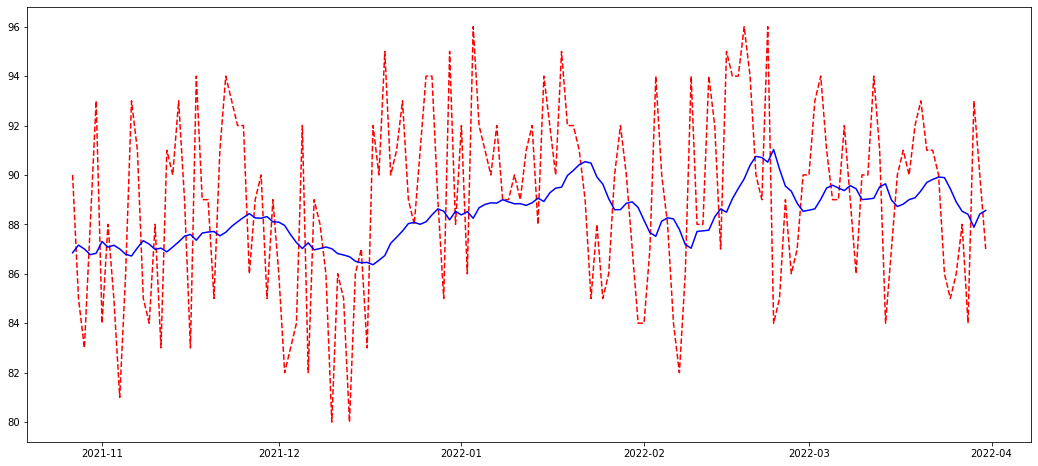

Mean Absolute Error is		: 3.0115225376226964
Root Mean Squared Error is	: 3.632782676258693


In [42]:
sc1_df, sc1_MAE, sc1_RMSE = forcast_scene(model_val_loc, period=1, X=X_test, y=y_test, date=date_test)

(0/155) updating 2021-10-27T00:00:00.000000000 into model
1/1 [==============================] - 3s 3s/step - loss: 0.4924 - root_mean_squared_error: 0.7017
(1/155) updating 2021-10-28T00:00:00.000000000 into model
1/1 [==============================] - 0s 21ms/step - loss: 0.2320 - root_mean_squared_error: 0.4816
(2/155) updating 2021-10-29T00:00:00.000000000 into model
1/1 [==============================] - 0s 18ms/step - loss: 0.7964 - root_mean_squared_error: 0.8924
(3/155) updating 2021-10-30T00:00:00.000000000 into model
1/1 [==============================] - 0s 21ms/step - loss: 0.0749 - root_mean_squared_error: 0.2737
(4/155) updating 2021-10-31T00:00:00.000000000 into model
1/1 [==============================] - 0s 21ms/step - loss: 1.8904 - root_mean_squared_error: 1.3749
(5/155) updating 2021-11-01T00:00:00.000000000 into model
1/1 [==============================] - 0s 18ms/step - loss: 0.5430 - root_mean_squared_error: 0.7369
(6/155) updating 2021-11-02T00:00:00.000000000 i

1/1 [==============================] - 0s 26ms/step - loss: 1.5772 - root_mean_squared_error: 1.2559
(52/155) updating 2021-12-18T00:00:00.000000000 into model
1/1 [==============================] - 0s 25ms/step - loss: 0.5929 - root_mean_squared_error: 0.7700
(53/155) updating 2021-12-19T00:00:00.000000000 into model
1/1 [==============================] - 0s 20ms/step - loss: 3.3924 - root_mean_squared_error: 1.8419
(54/155) updating 2021-12-20T00:00:00.000000000 into model
1/1 [==============================] - 0s 23ms/step - loss: 0.3799 - root_mean_squared_error: 0.6164
(55/155) updating 2021-12-21T00:00:00.000000000 into model
1/1 [==============================] - 0s 23ms/step - loss: 0.6169 - root_mean_squared_error: 0.7854
(56/155) updating 2021-12-22T00:00:00.000000000 into model
1/1 [==============================] - 0s 25ms/step - loss: 1.3793 - root_mean_squared_error: 1.1744
(57/155) updating 2021-12-23T00:00:00.000000000 into model
1/1 [==============================] - 0

1/1 [==============================] - 0s 21ms/step - loss: 0.8855 - root_mean_squared_error: 0.9410
(103/155) updating 2022-02-07T00:00:00.000000000 into model
1/1 [==============================] - 0s 18ms/step - loss: 1.6699 - root_mean_squared_error: 1.2923
(104/155) updating 2022-02-08T00:00:00.000000000 into model
1/1 [==============================] - 0s 20ms/step - loss: 0.0700 - root_mean_squared_error: 0.2645
(105/155) updating 2022-02-09T00:00:00.000000000 into model
1/1 [==============================] - 0s 22ms/step - loss: 2.4120 - root_mean_squared_error: 1.5530
(106/155) updating 2022-02-10T00:00:00.000000000 into model
1/1 [==============================] - 0s 19ms/step - loss: 0.0041 - root_mean_squared_error: 0.0643
(107/155) updating 2022-02-11T00:00:00.000000000 into model
1/1 [==============================] - 0s 20ms/step - loss: 0.0034 - root_mean_squared_error: 0.0583
(108/155) updating 2022-02-12T00:00:00.000000000 into model
1/1 [=============================

1/1 [==============================] - 0s 19ms/step - loss: 1.3003 - root_mean_squared_error: 1.1403
(154/155) updating 2022-03-30T00:00:00.000000000 into model
1/1 [==============================] - 0s 18ms/step - loss: 0.1241 - root_mean_squared_error: 0.3523
(155/155) updating 2022-03-31T00:00:00.000000000 into model
1/1 [==============================] - 0s 32ms/step - loss: 0.1213 - root_mean_squared_error: 0.3482


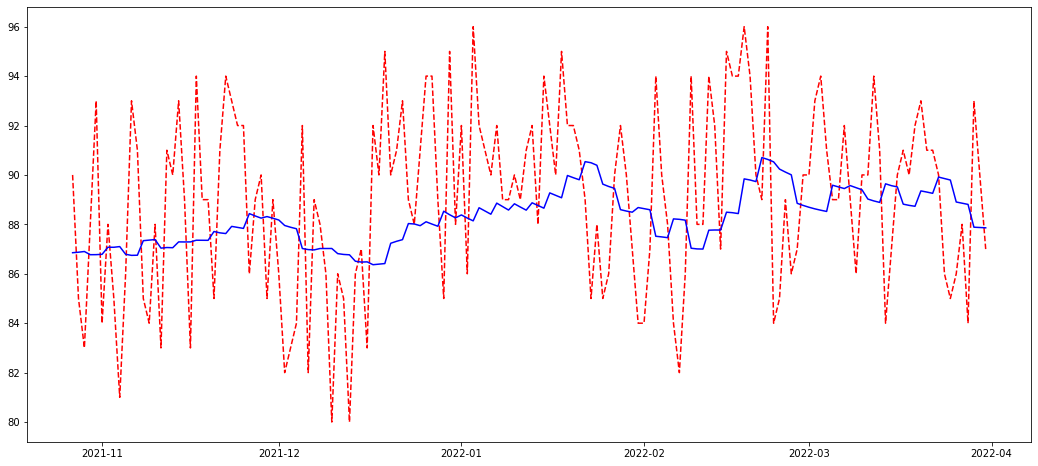

Mean Absolute Error is		: 3.114953896938226
Root Mean Squared Error is	: 3.722701836375955


In [43]:
sc2_df, sc2_MAE, sc2_RMSE = forcast_scene(model_val_loc, period=3, X=X_test, y=y_test, date=date_test)

(0/155) updating 2021-10-27T00:00:00.000000000 into model
1/1 [==============================] - 2s 2s/step - loss: 0.4924 - root_mean_squared_error: 0.7017
(1/155) updating 2021-10-28T00:00:00.000000000 into model
1/1 [==============================] - 0s 19ms/step - loss: 0.2320 - root_mean_squared_error: 0.4816
(2/155) updating 2021-10-29T00:00:00.000000000 into model
1/1 [==============================] - 0s 20ms/step - loss: 0.7964 - root_mean_squared_error: 0.8924
(3/155) updating 2021-10-30T00:00:00.000000000 into model
1/1 [==============================] - 0s 20ms/step - loss: 0.0749 - root_mean_squared_error: 0.2737
(4/155) updating 2021-10-31T00:00:00.000000000 into model
1/1 [==============================] - 0s 21ms/step - loss: 1.8904 - root_mean_squared_error: 1.3749
(5/155) updating 2021-11-01T00:00:00.000000000 into model
1/1 [==============================] - 0s 20ms/step - loss: 0.5430 - root_mean_squared_error: 0.7369
(6/155) updating 2021-11-02T00:00:00.000000000 i

1/1 [==============================] - 0s 19ms/step - loss: 1.5772 - root_mean_squared_error: 1.2559
(52/155) updating 2021-12-18T00:00:00.000000000 into model
1/1 [==============================] - 0s 21ms/step - loss: 0.5929 - root_mean_squared_error: 0.7700
(53/155) updating 2021-12-19T00:00:00.000000000 into model
1/1 [==============================] - 0s 24ms/step - loss: 3.3924 - root_mean_squared_error: 1.8419
(54/155) updating 2021-12-20T00:00:00.000000000 into model
1/1 [==============================] - 0s 18ms/step - loss: 0.3799 - root_mean_squared_error: 0.6164
(55/155) updating 2021-12-21T00:00:00.000000000 into model
1/1 [==============================] - 0s 20ms/step - loss: 0.6169 - root_mean_squared_error: 0.7854
(56/155) updating 2021-12-22T00:00:00.000000000 into model
1/1 [==============================] - 0s 18ms/step - loss: 1.3793 - root_mean_squared_error: 1.1744
(57/155) updating 2021-12-23T00:00:00.000000000 into model
1/1 [==============================] - 0

1/1 [==============================] - 0s 21ms/step - loss: 0.8855 - root_mean_squared_error: 0.9410
(103/155) updating 2022-02-07T00:00:00.000000000 into model
1/1 [==============================] - 0s 22ms/step - loss: 1.6699 - root_mean_squared_error: 1.2923
(104/155) updating 2022-02-08T00:00:00.000000000 into model
1/1 [==============================] - 0s 23ms/step - loss: 0.0700 - root_mean_squared_error: 0.2645
(105/155) updating 2022-02-09T00:00:00.000000000 into model
1/1 [==============================] - 0s 19ms/step - loss: 2.4120 - root_mean_squared_error: 1.5530
(106/155) updating 2022-02-10T00:00:00.000000000 into model
1/1 [==============================] - 0s 18ms/step - loss: 0.0041 - root_mean_squared_error: 0.0643
(107/155) updating 2022-02-11T00:00:00.000000000 into model
1/1 [==============================] - 0s 20ms/step - loss: 0.0034 - root_mean_squared_error: 0.0583
(108/155) updating 2022-02-12T00:00:00.000000000 into model
1/1 [=============================

1/1 [==============================] - 0s 19ms/step - loss: 1.3003 - root_mean_squared_error: 1.1403
(154/155) updating 2022-03-30T00:00:00.000000000 into model
1/1 [==============================] - 0s 19ms/step - loss: 0.1241 - root_mean_squared_error: 0.3523
(155/155) updating 2022-03-31T00:00:00.000000000 into model
1/1 [==============================] - 0s 18ms/step - loss: 0.1213 - root_mean_squared_error: 0.3482


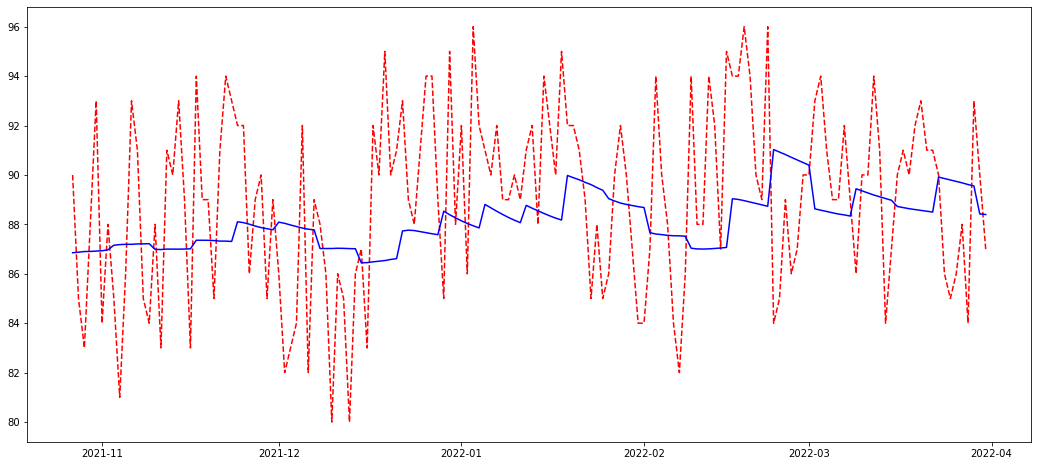

Mean Absolute Error is		: 3.2031780634170923
Root Mean Squared Error is	: 3.8288047271359016


In [44]:
sc3_df, sc3_MAE, sc3_RMSE = forcast_scene(model_val_loc, period=7, X=X_test, y=y_test, date=date_test)

# Collecting All Predictions Scenario Result

In [45]:
def plot_forecasts_result(df):
    title = 'Peramalan ' + ATTR_NAME + ' LSTM'
    
    plt.figure(figsize=(18,8))
    plt.title(title)
    plt.plot(df['scn-1'], 'r-', label='1-step forecast')
    plt.plot(df['scn-2'], 'b-', label='3-step forecast')
    plt.plot(df['scn-3'], 'g-', label='7-step forecast')
    plt.plot(df['Actuals'], color='black', linestyle=':' , label='Actuals')
    plt.legend()

In [46]:
def col_forcasts_err(res_df):
    for col in [x for x in range(len(forecasts_result.columns)-1)]:
        col_name = res_df.columns[col]
        MAE = mean_absolute_error(res_df['Actuals'], res_df[col_name])
        RMSE = sqrt(mean_squared_error(res_df['Actuals'], res_df[col_name]))
        print('Error for ', col_name)
        print(f'Mean Absolute Error is\t\t: {MAE}')
        print(f'Root Mean Squared Error is\t: {RMSE}')
        print()

In [47]:
sc1_df_cp = sc1_df.copy()
sc1_df_cp.columns = ['scn-1', 'Actuals']

sc2_df_cp = sc2_df.copy()
sc2_df_cp.columns = ['scn-2', 'Actuals']

sc3_df_cp = sc3_df.copy()
sc3_df_cp.columns = ['scn-3', 'Actuals']

In [48]:
forecasts_result = pd.concat([sc1_df_cp[[sc1_df_cp.columns[0]]],
                              sc2_df_cp[[sc2_df_cp.columns[0]]],
                              sc3_df_cp[[sc3_df_cp.columns[0]]],
                              sc1_df_cp[[sc3_df_cp.columns[1]]]
                             ],
                               axis='columns')

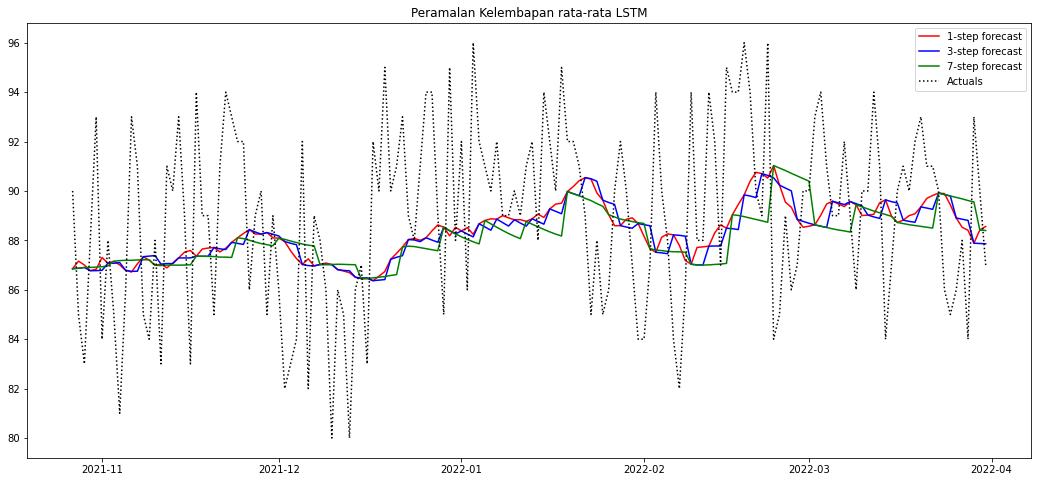

In [49]:
plot_forecasts_result(forecasts_result)

In [50]:
col_forcasts_err(forecasts_result)

Error for  scn-1
Mean Absolute Error is		: 3.0115225376226964
Root Mean Squared Error is	: 3.632782676258693

Error for  scn-2
Mean Absolute Error is		: 3.114953896938226
Root Mean Squared Error is	: 3.722701836375955

Error for  scn-3
Mean Absolute Error is		: 3.2031780634170923
Root Mean Squared Error is	: 3.8288047271359016



## Saving forecasts result

In [51]:
forecasts_result.to_csv('LSTM_results_temp/'+ATTR_CODE+'_n'+str(NEURON_LAYER)+'_e'+str(EPOCH)+'.csv')

# Calling Forecasting Result

In [52]:
FILE_NEURON = NEURON_LAYER
FILE_EPOCH = EPOCH

In [53]:
df_call = pd.read_csv('LSTM_results_temp/'+ATTR_CODE+'_n'+str(FILE_NEURON)+'_e'+str(FILE_EPOCH)+'.csv')
df_call.date = pd.to_datetime(df_call.date, format='%Y-%m-%d')
df_call.set_index('date', inplace=True)
df_call.head()

,scn-1,scn-2,scn-3,Actuals
date,,,,
2021-10-27,86.852380,86.852380,86.85238,90.0
2021-10-28,87.160416,86.872680,86.87268,85.0
2021-10-29,87.002815,86.901300,86.90130,83.0
2021-10-30,86.772130,86.772130,86.90329,88.0
2021-10-31,86.832880,86.774155,86.91650,93.0


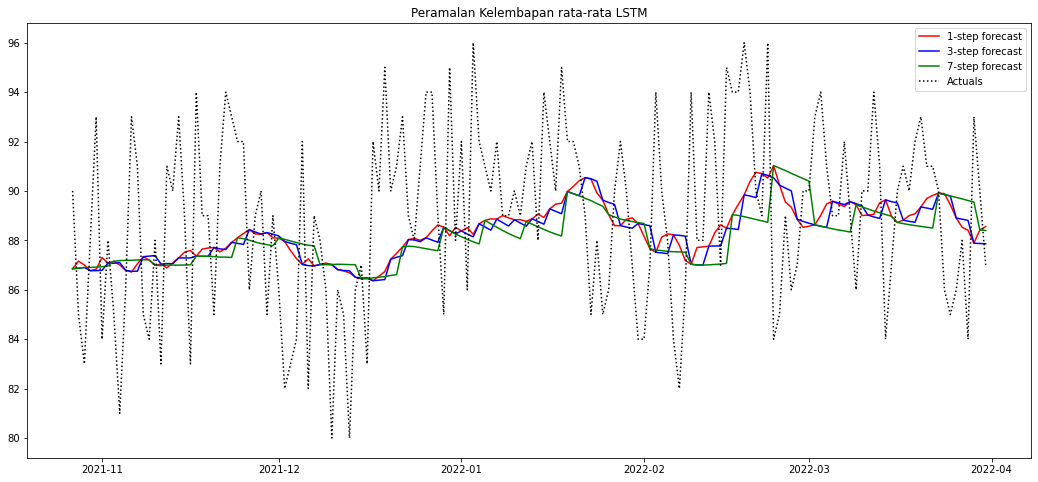

In [54]:
plot_forecasts_result(df_call)

In [55]:
col_forcasts_err(df_call)

Error for  scn-1
Mean Absolute Error is		: 3.0115223333333327
Root Mean Squared Error is	: 3.632782505167119

Error for  scn-2
Mean Absolute Error is		: 3.114953653846154
Root Mean Squared Error is	: 3.722701717267736

Error for  scn-3
Mean Absolute Error is		: 3.203178006410256
Root Mean Squared Error is	: 3.8288047039957824

